In [1]:
import numpy as np

from src.behavior import get_actor
from src.eval.eval_utils import get_model_from_api_or_cached


from src.common.files import get_processed_paths, path_override
from torch.utils.data import DataLoader
from src.dataset.dataset import FurnitureImageDataset
from src.train.bc import to_native

import torch
from src.behavior.base import Actor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tqdm import tqdm

Importing module 'gym_38' (/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.3.0+cu121
Device count 1
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...
21:26:54 INFO: This is wandb-osh v1.2.2 using communication directory /afs/csail.mit.edu/u/a/ankile/.wandb_osh_command_dir
/data/scratch/ankile/robust-rearrangement/src/train/bc.py:79: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../config", config_name="base")


In [2]:
import matplotlib.pyplot as plt

# plt.rcParams["font.family"] = "Times New Roman"

In [3]:
run_id_naive = "real-one_leg-cotrain-2/g1gyne9t"
run_id_confusion4 = "real-one_leg-cotrain-2/7grrzinv"
run_id_confusion3 = "real-one_leg-cotrain-2/xwawbdtk"
run_id_confusion2 = "real-one_leg-cotrain-2/f7usetuv"

In [4]:
# Get the config to load in the standard model with only pretrained weights
cfg, _ = get_model_from_api_or_cached(run_id_naive, "latest", wandb_mode="online")

cfg

{'data': {'suffix': None, 'furniture': ['one_leg_render_demos_brighter', 'one_leg_render_rppo_brighter', 'one_leg_render_demos_black', 'one_leg_render_rppo_black', 'one_leg_full'], 'pad_after': True, 'randomness': ['low', 'med', 'med_perturb'], 'test_split': 0.05, 'data_subset': 200, 'demo_source': ['teleop', 'rollout'], 'environment': ['real', 'sim'], 'obs_horizon': 1, 'demo_outcome': 'success', 'pred_horizon': 32, 'augment_image': True, 'normalization': 'min_max', 'action_horizon': 8, 'max_episode_count': {'one_leg_full': {'teleop': {'low': {'success': 40}}}}, 'dataloader_workers': 20, 'include_future_obs': False, 'data_paths_override': None, 'minority_class_power': False, 'predict_past_actions': False}, 'actor': {'name': 'diffusion', 'loss_fn': 'MSELoss', 'clip_sample': True, 'flatten_obs': False, 'obs_horizon': 1, 'pred_horizon': 32, 'beta_schedule': 'squaredcos_cap_v2', 'action_horizon': 8, 'projection_dim': 128, 'diffusion_model': {'name': 'transformer', 'n_emb': 256, 'n_head': 4

In [5]:
actor: Actor = get_actor(cfg=cfg, device="cuda")

/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current 

In [6]:
# Turn off the actor's training mode and gradient computation
actor.eval()

for param in actor.parameters():
    param.requires_grad = False

In [7]:
if cfg.data.data_paths_override is None:
    data_path = get_processed_paths(
        controller=to_native(cfg.control.controller),
        domain=to_native(cfg.data.environment),
        task=to_native(cfg.data.furniture),
        demo_source=to_native(cfg.data.demo_source),
        randomness=to_native(cfg.data.randomness),
        demo_outcome=to_native(cfg.data.demo_outcome),
        suffix=to_native(cfg.data.suffix),
    )
else:
    data_path = path_override(cfg.data.data_paths_override)

print(f"Using data from {data_path}")

dataset = FurnitureImageDataset(
    dataset_paths=data_path,
    pred_horizon=cfg.data.pred_horizon,
    obs_horizon=cfg.data.obs_horizon,
    action_horizon=cfg.data.action_horizon,
    # data_subset=cfg.data.data_subset,
    data_subset=5,
    control_mode=cfg.control.control_mode,
    predict_past_actions=cfg.data.predict_past_actions,
    pad_after=cfg.data.get("pad_after", True),
    max_episode_count=cfg.data.get("max_episode_count", None),
    minority_class_power=cfg.data.get("minority_class_power", False),
)

# Create dataloaders
trainload_kwargs = dict(
    dataset=dataset,
    # batch_size=cfg.training.batch_size,
    batch_size=64,
    num_workers=cfg.data.dataloader_workers,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    persistent_workers=False,
)

trainloader = DataLoader(**trainload_kwargs)

Loading zarr files:   0%|          | 0/7 [00:00<?, ?it/s]























































Loading zarr files:  14%|█▍        | 1/7 [01:17<07:42, 77.02s/it]















Loading zarr files:  29%|██▊       | 2/7 [01:22<02:54, 34.92s/it]















Loading zarr files:  43%|████▎     | 3/7 [01:27<01:25, 21.48s/it]















Loading zarr files:  57%|█████▋    | 4/7 [01:33<00:45, 15.21s/it]















Loading zarr files:  71%|███████▏  | 5/7 [01:38<00:23, 11.57s/it]















Loading zarr files:  86%|████████▌ | 6/7 [01:43<00:09,  9.38s/it]















Loading zarr files: 100%|██████████| 7/7 [01:49<00:00, 15.58s/it]


In [8]:
def get_embeddings(actor: Actor, batch):
    img1 = batch["color_image1"].to("cuda").squeeze()
    emb1 = actor.encoder1_proj(actor.encoder1(img1))

    img2 = batch["color_image2"].to("cuda").squeeze()
    emb2 = actor.encoder2_proj(actor.encoder2(img2))

    return emb1, emb2

In [9]:
def get_embeddings_and_domain_labels(actor: Actor, trainloader, sample_size=None):
    # Initialize empty lists to store embeddings and domain labels
    embeddings = []
    domain_labels = []

    # Iterate over the dataset
    for batch in tqdm(trainloader):
        emb1, emb2 = get_embeddings(actor, batch)

        # Concatenate the embeddings into a single tensor of shape (batch_size, 2 * embedding_size)
        emb = torch.cat([emb1, emb2], dim=1)
        embeddings.append(emb.cpu().numpy())

        domain_labels.extend(batch["domain"].cpu().numpy().tolist())

    # Concatenate the embeddings and convert to numpy array
    embeddings = np.concatenate(embeddings, axis=0)
    domain_labels = np.array(domain_labels).reshape(-1)

    # Print the average standard deviation of the embeddings
    print(
        f"Average standard deviation of embeddings: {np.mean(np.std(embeddings, axis=0))}"
    )

    # If sample_size is not None, sample a subset of the embeddings and domain labels
    # Stratified by domain label
    if sample_size is not None:
        sampled_embeddings = []
        sampled_domain_labels = []

        for domain_label in np.unique(domain_labels):
            idx = np.where(domain_labels == domain_label)[0]
            idx = np.random.choice(idx, size=sample_size, replace=False)

            sampled_embeddings.append(embeddings[idx])
            sampled_domain_labels.extend(domain_labels[idx].tolist())

        embeddings = np.concatenate(sampled_embeddings, axis=0)
        domain_labels = np.array(sampled_domain_labels).reshape(-1)

    return embeddings, domain_labels

In [19]:
simcolor = "#2398DA"
realcolor = "#E34A6F"


def visualize_embeddings_tsne(embeddings, domain_labels, title=None):
    # Apply t-SNE to reduce the dimensionality to 2
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Split the embeddings based on the domain labels
    embeddings_domain1 = embeddings_tsne[domain_labels == 0]
    embeddings_domain2 = embeddings_tsne[domain_labels == 1]

    # Plot the embeddings in two different colors
    plt.figure(figsize=(4, 4))
    plt.scatter(
        embeddings_domain1[:, 0],
        embeddings_domain1[:, 1],
        color=simcolor,
        label="Sim",
        alpha=0.2,
        s=2,
    )
    plt.scatter(
        embeddings_domain2[:, 0],
        embeddings_domain2[:, 1],
        color=realcolor,
        label="Real",
        alpha=0.2,
        s=2,
    )
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.legend(frameon=False)

    if title is not None:
        plt.title(title)
    plt.show()


def visualize_embeddings_pca(embeddings, domain_labels, title=None):
    # Apply PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)

    # Split the embeddings based on the domain labels
    embeddings_domain1 = embeddings_pca[domain_labels == 0]
    embeddings_domain2 = embeddings_pca[domain_labels == 1]

    # Plot the embeddings in two different colors
    plt.figure(figsize=(4, 4))
    plt.scatter(
        embeddings_domain1[:, 0],
        embeddings_domain1[:, 1],
        color=simcolor,
        label="Sim",
        alpha=0.2,
        s=2,
    )
    plt.scatter(
        embeddings_domain2[:, 0],
        embeddings_domain2[:, 1],
        color=realcolor,
        label="Real",
        alpha=0.2,
        s=2,
    )
    # plt.xlabel('PCA Dimension 1')
    # plt.ylabel('PCA Dimension 2')
    plt.legend(frameon=False)

    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
from pytorch3d.transforms import so3_exponential_map, so3_relative_angle

### Plot embeddings for the pretrained R3M model

In [20]:
sample_size = 5_000

100%|██████████| 541/541 [00:32<00:00, 16.86it/s]


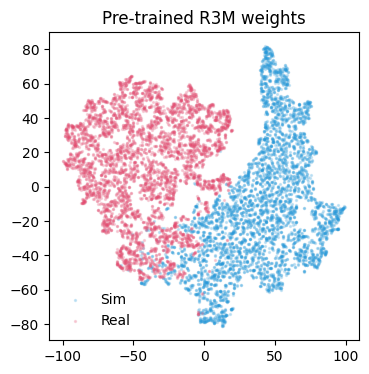

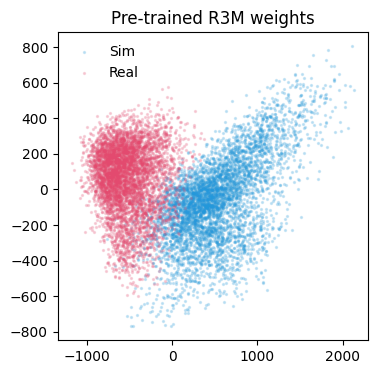

In [21]:
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

title = "Pre-trained R3M weights"
visualize_embeddings_tsne(embeddings, domain_labels, title=title)
visualize_embeddings_pca(embeddings, domain_labels, title=title)

### Plot embeddings for co-trained model with no tricks

100%|██████████| 541/541 [00:33<00:00, 16.38it/s]


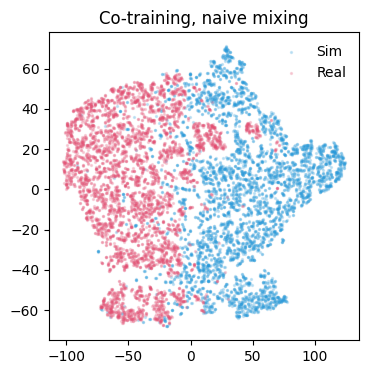

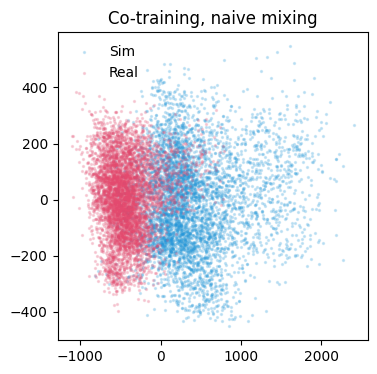

In [22]:
# Get weights
_, wts = get_model_from_api_or_cached(run_id_naive, "latest", wandb_mode="online")

# Load the weights into the actor
state_dict = torch.load(wts)
if "model_state_dict" in state_dict:
    actor.load_state_dict(state_dict["model_state_dict"])
else:
    actor.load_state_dict(state_dict)


# Get the embeddings and domain labels
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

# Visualize the embeddings using t-SNE and PCA
title = "Co-training, naive mixing"
visualize_embeddings_tsne(embeddings, domain_labels, title=title)
visualize_embeddings_pca(embeddings, domain_labels, title=title)

### Plot embeddings for co-trained model with 1e-4 confusion loss

100%|██████████| 541/541 [00:31<00:00, 16.91it/s]


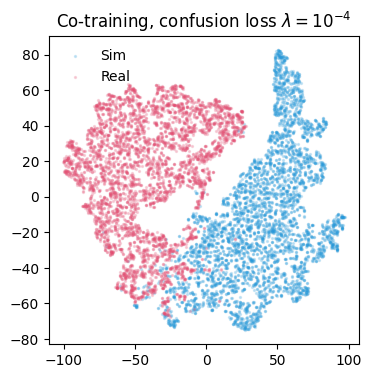

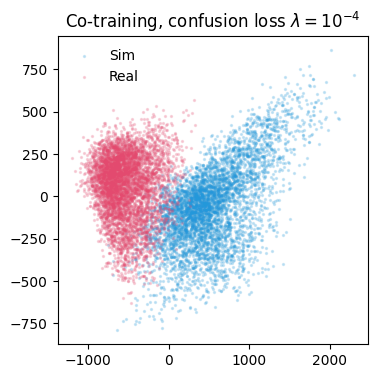

In [23]:
# Get weights
_, wts = get_model_from_api_or_cached(run_id_confusion4, "latest", wandb_mode="online")

# Load the weights into the actor
state_dict = torch.load(wts)
if "model_state_dict" in state_dict:
    actor.load_state_dict(state_dict["model_state_dict"])
else:
    actor.load_state_dict(state_dict)

# Get the embeddings and domain labels
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

# Visualize the embeddings using t-SNE and PCA
title = "Co-training, confusion loss $\\lambda=10^{-4}$"
visualize_embeddings_tsne(embeddings, domain_labels, title=title)
visualize_embeddings_pca(embeddings, domain_labels, title=title)

### Plot embeddings for co-trained model with 1e-3 confusion loss

100%|██████████| 541/541 [00:31<00:00, 16.93it/s]


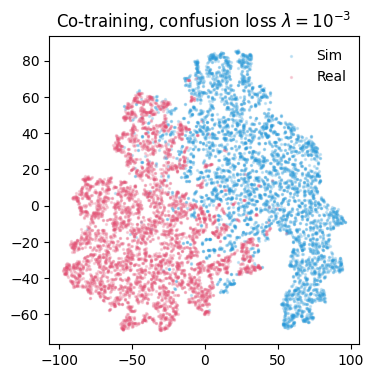

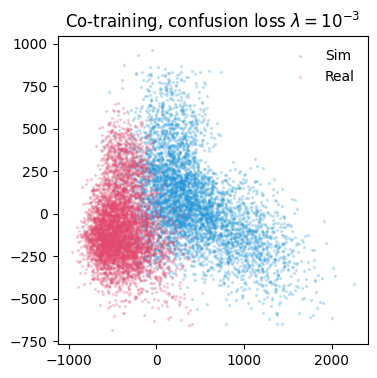

In [24]:
# Get weights
_, wts = get_model_from_api_or_cached(run_id_confusion3, "latest", wandb_mode="online")

# Load the weights into the actor
state_dict = torch.load(wts)
if "model_state_dict" in state_dict:
    actor.load_state_dict(state_dict["model_state_dict"])
else:
    actor.load_state_dict(state_dict)

# Get the embeddings and domain labels
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

# Visualize the embeddings using t-SNE and PCA
title = "Co-training, confusion loss $\\lambda=10^{-3}$"
visualize_embeddings_tsne(embeddings, domain_labels, title=title)
visualize_embeddings_pca(embeddings, domain_labels, title=title)

100%|██████████| 541/541 [00:31<00:00, 17.06it/s]


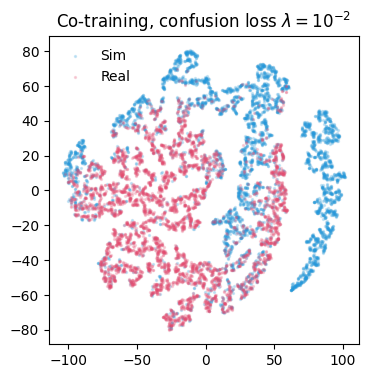

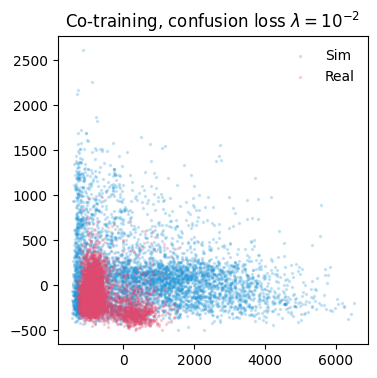

In [25]:
# Get weights
_, wts = get_model_from_api_or_cached(run_id_confusion2, "latest", wandb_mode="online")

# Load the weights into the actor
state_dict = torch.load(wts)
if "model_state_dict" in state_dict:
    actor.load_state_dict(state_dict["model_state_dict"])
else:
    actor.load_state_dict(state_dict)

# Get the embeddings and domain labels
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

# Visualize the embeddings using t-SNE and PCA
title = "Co-training, confusion loss $\\lambda=10^{-2}$"
visualize_embeddings_tsne(embeddings, domain_labels, title=title)
visualize_embeddings_pca(embeddings, domain_labels, title=title)

In [27]:
embeddings.mean(axis=0)

array([-1.2189532e+03,  5.0964551e+02, -7.7183838e+02, -1.5778461e+03,
       -3.9291269e+02, -1.3671062e+03,  7.5005243e+02,  8.6131763e+02,
       -1.0808610e+03,  1.3588441e+03,  5.1429773e+02,  8.6308209e+02,
       -1.0089327e+03,  1.0125116e+03,  1.0350303e+03,  1.4368250e+02,
       -1.2854965e+03, -1.5410604e+03, -1.5524781e+03,  1.5979989e+03,
        1.4036917e+03,  1.5230468e+03,  1.5059836e+03,  1.3485695e+03,
        4.9522745e+02,  4.8429039e+01,  1.0440638e+03, -1.4398643e+03,
        1.1440382e+03,  1.5508651e+03, -9.9548102e+02,  8.1285980e+02,
        4.9909146e+02,  1.0820706e+03, -1.4798599e+03, -1.3655789e+03,
        1.4483774e+03,  1.0833558e+03, -1.2139167e+03, -5.6049371e+02,
        4.8147092e+00,  1.1385000e+03,  1.2381002e+03, -1.5857181e+03,
       -1.6118590e+03, -2.2940428e+02, -8.4561267e+02,  1.4927457e+03,
        1.1649904e+03,  7.6138959e+02, -1.9001180e+02, -1.5326261e+03,
        3.7973114e+02,  1.5139662e+03, -1.3406541e+03, -1.5261024e+03,
      